In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab08B.ipynb")

---

<h3><center>E7 -  Introduction to Programming for Scientists and Engineers</center></h3>

<h2><center>Lab session #08-B <br></center></h2>

<h1><center>Numerical integration<br></center></h1>

---

In [2]:
from resources.hashutils import *
import numpy as np
import matplotlib.pyplot as plt

# Question 1: Falling watermelon

As part of the special effects team with a movie production company, you are tasked with computing the precise trajectory of a watermelon as it falls vertically from a height of 15 meters. The camera crew needs this calculation to be done with an accuracy of 1 cm, meaning that the true position of the watermelon is within 1 cm of its predicted position at all times. The Big Brains department has produced an exact formula for the speed of the watermelon as it falls. 

$$v(t) = - \sqrt{\frac{gm}{c}}\tanh\left(\sqrt{\frac{g c}{m}}\: t\right)$$

Here $t$ is the time in seconds from the instant the watermelon is released, $g=9.81\;m/s^2$ is the acceleration due to gravity, $m=10\;kg$ is the mass of the watermelon, and $c=0.013\;kg/m$ is a coefficient related to air resistance. 

Notice that this function relates the veolocity of the watermelon to the *hyperbolic tangent* function. As shown in the figure below, this function rises from 0 at the initial time, toward 1 as time increases. Hence the velocity of the watermelon goes from 0 to a terminal velocity of **negative** $\sqrt{gm/c}$. The negative sign in the formula indicates that the watermelon is falling downward. 

<img src="resources/tanh.png" width="600"/>

Having $v(t)$ as a function of time allows one to compute its position using the integration formula:

$$ x(t) = x(0) + \int_{0}^{t} v(\tau) d\tau$$

Here $x(0)\!=\!15$ is the position of the watermelon when the clock starts. 

In this question we will use SciPy's implementation of the trapezoidal rule to numerically compute $x(t)$ from $v(t)$.

We begin by defining the constants.

In [3]:
g = 9.81
m = 10
c = 0.013

## Question 1.1: Create the velocity function

Create a function called `get_velocity(t)` that takes a value (or a NumPy array) `t` of time(s) in seconds as input and returns the velocity of the watermelon at that time (those times) according to the formula provided in the introduction.

**Hint**: [np.tanh](https://numpy.org/doc/stable/reference/generated/numpy.tanh.html)

In [4]:
def get_velocity(t):
    velocity = -(np.sqrt(g*m/c))*np.tanh(np.sqrt(g*c/m)*t)
    return velocity

In [5]:
grader.check("q1p1")

q1p1 results: All test cases passed!

## Question 1.2: Create a grid of points in time

To compute the numerical integral, we will need a grid of points in time. To keep things simple, we will use a *uniformly spaced* grid. Write a function called `eval_vel_on_grid(tf,n)` that takes as inputs 
1. a *final time* `tf` in seconds, and
2. a number of points `n`.

Here is the specification for the function.
+ It should return a NumPy array of `n` equally spaced time instants ranging from 0 to `tf` (inclusive). Call this array `t`.
+ It should also return a NumPy array called `v` of watermelon velocity values evaluated at those times. 
+ Both of these arrays should have the same shape and should be returned in the order `t, v`.

In [6]:
def eval_vel_on_grid(tf,n):
    t = np.linspace(0,tf,n)
    v = get_velocity(t)
    return t, v

In [7]:
grader.check("q1.2")

q1.2 results: All test cases passed!

## Question 1.3: Numerical integration

Create a function called `compute_position(tf, n)` that takes the same inputs as `eval_speed_on_grid`, and returns the time grid `t`, and the corresponding velocity and position values `v` and `x`(in that order). 

`x` should be a NumPy array with the same shape as `v` and `t`. 

The order of the variables returned by this function should be `t, v, x`.

To accomplish this we will use SciPy's [`cumulative_trapezoid`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.cumulative_trapezoid.html) function. This function takes as input the array of velocity values along with the corresponding array of time instants. It returns an array of numerically integrated values. In other words, it returns an estimate of the total distance traveled by the watermelon at each instant of time. This is the integral (the second term) in the formula
$$ x(t) = x(0) + \int_{0}^{t} v(\tau) d\tau$$
To this estimate we must add the initial position (`x[0]=15`) to obtain the estimated position.

**Technical note on** [`cumulative_trapezoid`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.cumulative_trapezoid.html),
+ When you run `d=cumulative_trapezoid(v, t)` you will notice that it returns an array that is 1 element shorter than `t` and `v`. This is because each value of `d` corresponds to the accumulated area over the intervals of time, and there is one fewer intervals than time instants. For example, the value `d[0]` is the integral over the interval `[t[0],t[1]]` so it actually corresponds to the distance traveled by the watermelon at time `t[1]`. But we would rather have a position array that is the same size as `v` and `t`, and whose values are properly aligned with `t`. To correct this, you should pass the keyword argument `initial=0` to the `cumulative_trapezoid` function. This will insert a 0 into the first position of `d`. Then `d` will have the same shape as `t` and `v`, and `d[i]` will correspond to the distance travelled by the watermelon at time `t[i]`, as desired.

**Note**: 
+ Since the velocity is negative, its integral is also negative, and so we should expect that `cumulative_trapezoid` will return negative numbers. This makes sense, since the watermelon is falling and hence its position (height) is decreasing.


In [8]:
from scipy.integrate import cumulative_trapezoid

def compute_position(tf, n):
    t = np.linspace(0,tf,n)
    v = get_velocity(t)
    d = cumulative_trapezoid(v,t,initial=0)
    x = np.empty(len(t))
    x[0]=15
    x = x[0] + d
    return t, v, x

In [9]:
grader.check("q1p")

q1p results: All test cases passed!

## Question 1.4: Error bound 

Next we will compute an upper bound on the error of the numerical integration. Recall from lecture that the error in a single step of the trapezoidal rule is proportional to the maximum of the second derivative of the function being integrated ($M_{2}$), and also proportional to the square of the step size ($\Delta t$).

$$\left|\text{total error}\right|   \leq  \frac{(b-a)\Delta t^2}{12} M_{2}  $$

Here $b-a$ is the size of the full integration interval, which equals $t_f$ in our case.

$M_{2}$ is the maximum of $\left|\ddot{v}(t)\right|$ over a single time step. This has to be estimated. 

 $\ddot{v}(t)$ can be computed with the help of Newton's second law. It was found by the Big Brains department to be:

$$\ddot{v}(t) = \frac{2c}{m}v(t) \left( \frac{c}{m} v^2(t) -g\right)$$

We've already established that the terminal velocity of the watermelon is $-\sqrt{gm/c}$. We can use this fact and the formula above to put an upper limit on the magnitude of $\ddot{v}(t)$.

$$
\begin{align*}\left|\ddot{v}(t)\right| &= \frac{2c}{m}\left|v(t)\right| \left|\left( \frac{c}{m} v^2(t) -g\right)\right| \\
&\leq \frac{2c}{m}\sqrt{\frac{gm}{c}} g \\
&= 2g\sqrt{\frac{gc}{m}} \\
\end{align*}
$$

(The second line in this derivation is non-trivial, but it can be obtained from the fact that $v(t)>-\sqrt{gm/c}$.)

We have found that $\left|\ddot{v}(t)\right|\leq 2g\sqrt{gc/m}$, and hence $M_2=2g\sqrt{gc/m}$ can be used as an upper bound. Plugging this into the formula for maximum total error we get:


$$\left|\text{total error}\right|   \leq  g\sqrt{\frac{gc}{m}}\frac{ \Delta t^2 }{6} t_f$$


Write a function called `trapezoidal_error(tf, n)` to compute this error bound given a final time `tf` and number of grid points `n`. 

In [10]:
def trapezoidal_error(tf, n):
    total_error = g*(np.sqrt(g*c/m))*((tf/(n-1))**2/6)*tf
    return abs(total_error)

In [11]:
trapezoidal_error(2, 20)*100

0.40917276787698736

In [12]:
grader.check("q1p4")

q1p4 results: All test cases passed!

## Question 1.5:  Plot the trajectory of the watermelon

Create the plot shown below of the position $x(t)$ of the watermelon versus time. The plot should have these characteristics:

+ `tf=2` and `n=20`
+ Both the line and the markers should be made with the `plot` function. 
+ Plot the trajectory with a solid line (`'-'`) and the watermelon with an `o` marker. 
+ The title of the plot should read `'Watermelon trajectory (total error=XXX cm)'`, where `XXX` is the total integration error (computed with `trapezoidal_error`), expressed in centimeters, with a 2-digit precision (e.g. '3.45' - although this is not the correct value).

**Desired result** (with the correct error value instead of 'XXX')

<img src="resources/trajplot.png" width="600"/>

**Notes**: 

+ The watermelon-like markers colors are not autograded. Those were done with 
` 
markerfacecolor='red',
markeredgecolor='green',
markeredgewidth=3,
markersize=12
`

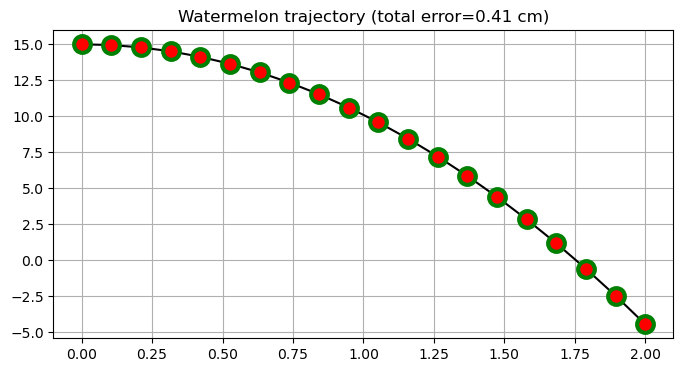

In [13]:
tf = 2
n = 20
compute_position(tf, n)
fig1, ax1 = plt.subplots(figsize = (8,4))
ax1.plot(compute_position(tf, n)[0],compute_position(tf, n)[2], linestyle = '-', color = 'black', marker = 'o',
         markerfacecolor='red', markeredgecolor='green', markeredgewidth=3, markersize=12)
ax1.set_title(f"Watermelon trajectory (total error={trapezoidal_error(tf, n)*100:.2} cm)")
ax1.grid()

In [14]:
grader.check("q1p5")

q1p5 results: All test cases passed!

## Question 1.6: When will the watermelon hit the ground?

Notice in the plot from the previous part that the watermelon should hit the ground at some time between 1.5 seconds and 2 seconds after it is released. Next you will find a better estimate of this time by locating the precise intersection of the watermelon's trajectory with the horizontal line at $x=0$. 

To do this, implement the function `compute_impact_time(tf, n)` that take the final time `tf` and the number of grid points `n`, and does the following:
1. Used `compute_position` to obtain the trajectory  `tf=2` and `n=20` (as in part 1.5)
2. Find `ipos` and `ineg`, the indexes corresponding to the last positive value of `x` and the first negative value of `x`, respectively. 
3. Computes `tg`, watermelon-to-ground impact time, based on `t[ineg]`, `t[ipos]`, `x[ineg]`, and `x[ipos]`. Here you will have to derive a formula for `tg` by assuming constant speed between `t[ineg]` and `t[ipos]` (ie that the line joining the two red dots in the figure below is straight).
4. Returns `ineg`, `ipos`, and `tg` (in that order).

<img src="resources/t0.png" width="400"/>

In [15]:
def compute_impact_time(tf, n):
    t, v, x = compute_position(tf, n)
    ineg = min(np.where(x<0)[0])
    ipos = max(np.where(x>0)[0])
    tg = t[ineg] + (t[ipos]-t[ineg])*(x[ineg]/(x[ineg]-x[ipos]))
    return ineg, ipos, tg 

In [16]:
# Use this cell to test your code
compute_impact_time(2, 20)

(17, 16, 1.7537627032980467)

In [17]:
grader.check("q1p6")

q1p6 results: All test cases passed!

## Question 1.7: Total error as a function of `n`

Next we will use our `trapezoidal_error` function to find the dependence of the error bound on the number `n` of grid points. 
To do this we will create a plot such as the one shown below that shows the error bound as a function of `n`. We can observe in this plot that, as expected, the error decreases as we increase the density of grid points. Our goal is to determine the minimum number of grid points needed to meet the requirement of ``no more than 1cm of error''.

<img src="resources/errorplot.png" width="600"/>

Here are the specifications for the plot:
+ The error bound is computed with `tf=2`
+ The number of grid points `n` ranges from 2 to 20 inclusive.
+ Errors are expressed in centimeters.
+ The x-axis has a linear scale. 
+ The y-axis has a logarithmic scale.
+ A red-dashed horizontal line indicates the error threshold of 1 cm. 
+ Ticks are placed along the x-axis at every value of `n`.
+ The plot has a grid.
+ Include a legend with the error bound labeled as 'error bound' and the threshold labeled as 'threshold'.

**Note**
+ In the image above, we've zoomed in and hidden the tick labels, so as to not give away the answer.
+ Plot the red-dashed horizontal threshold line using `plot` or [`axhline`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html), but **not hlines**, otherwise the autograder will fail. 

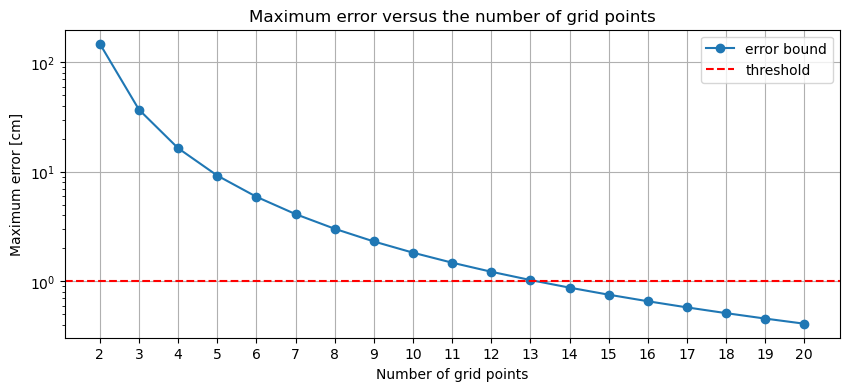

In [18]:
tf = 2
n = np.linspace(2,20,19)
fig2, ax2 = plt.subplots(figsize=(10,4))
ax2.plot(n, trapezoidal_error(tf, n)*100,marker = "o",label = "error bound")
ax2.axhline(1,linestyle = "--", color = 'red', label = 'threshold')
ax2.grid()
ax2.set_xticks(n)
ax2.set_yscale('log')
ax2.set_title('Maximum error versus the number of grid points')
ax2.set_xlabel('Number of grid points')
ax2.set_ylabel('Maximum error [cm]')
ax2.legend()


In [19]:
grader.check("q1p7")

q1p7 results: All test cases passed!

## Question 1.8: Minimum `n`

According to the plot of part 1.7, what is the smallest value of `n` that guarantees an error of no more than 1 cm?

In [20]:
nmin = 13

In [21]:
grader.check("q1p8")

q1p8 results: All test cases passed!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [22]:
grader.check_all()

q1.2 results: All test cases passed!

q1p results: All test cases passed!

q1p1 results: All test cases passed!

q1p4 results: All test cases passed!

q1p5 results: All test cases passed!

q1p6 results: All test cases passed!

q1p7 results: All test cases passed!

q1p8 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Make sure you submit the .zip file to Gradescope.

In [23]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)